TITLE:
Predicting whether fasting blood sugar level is higher than 120 mg/dL in an individual using age and serum cholesterol levels.

INTRODUCTION: 

Elevated fasting blood sugar levels are indicative of diabetes, and it is considered prediabetes if the levels are between 100 and 125 mg/dL. Levels higher than 125 mg/dL are considered diabetes. Factors that increase blood sugar levels are high serum cholesterol levels and increased age. Cholesterol, particularly high low-density lipoprotein, can contribute to elevated blood glucose levels. Cholesterol levels increase with age, along with blood sugar levels, especially around 70 years of age for both sexes.  Therefore, my question is "Can increasing age and serum cholesterol predict whether an individual has a fasting blood sugar level higher than 120 mg/dL using the Cleveland database?". I aim to predict whether a person has a fasting blood sugar level higher than 120 mg/dL using age and serum cholesterol levels as predictors, applying the K-nearest neighbours algorithm. First, I will tidy the data by narrowing the age above 55 and cholesterol levels above 300. 

In [1]:
library(tidyverse)
library(cowplot)
library(scales)
library(readr)
library(repr)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘cowplot’ was built under R version 4.3.2”

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


── Attaching packages ────────────────────────────────────── tidym

PRELIMINARY EXPLORATORY ANALYSIS and METHODS: 

I will load the data using a relative path.

In [2]:
training_data <- read_csv("data/heart_disease/processed.cleveland.data", col_names = FALSE)
head(training_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Secondly, I will select and rename the columns X1, X5, X6 to "age", "cholesterol", and "fasting_blood_sugar". After filtering, I will change the fasting_blood_sugar column data type such that it is categorical.

In [3]:
selected_data <- training_data |>
    rename(age = X1, cholesterol = X5, fasting_blood_sugar = X6) |>
     select(fasting_blood_sugar, cholesterol, age) |>
    filter(age > 55, cholesterol > 300) |>
    mutate(fasting_blood_sugar = as_factor(fasting_blood_sugar)) 
head(selected_data)

fasting_blood_sugar,cholesterol,age
<fct>,<dbl>,<dbl>
0,354,57
0,340,58
0,335,64
0,302,71
0,330,61
1,417,65


I will recode the variable's name to "over" from "1" to indicate that the blood sugar level is over 120 mg/dL and "below" from "0" to indicate a blood sugar level lower than 120 mg/dL.

In [4]:
mutated_data <- selected_data |>
    mutate(fasting_blood_sugar = recode(fasting_blood_sugar, "1" = "over", "0" = "below"))
head(mutated_data)

fasting_blood_sugar,cholesterol,age
<fct>,<dbl>,<dbl>
below,354,57
below,340,58
below,335,64
below,302,71
below,330,61
over,417,65


Finally, I specified 75% of the training data and 25% of the testing data to build our model.

In [5]:

set.seed(3456) 
cleveland_split <- initial_split(mutated_data, prop = 0.75, strata = fasting_blood_sugar)  
cleveland_train<- training(cleveland_split)   
cleveland_test<- testing(cleveland_split)


Next, I made a table that summarizes the number of observations in each variable in the fasting blood sugar column for both age and cholesterol levels. 

In [6]:
cleveland_table <- cleveland_train |>
        group_by(age) |>
        summarize(
    over = sum(fasting_blood_sugar == "over"),
    below = sum(fasting_blood_sugar == "below"))
cleveland_table

age,over,below
<dbl>,<int>,<int>
56,0,1
57,0,1
58,1,1
59,0,1
60,0,2
61,0,2
62,0,1
63,0,1
64,0,4


In [7]:
cleveland_table_2 <- cleveland_train |>
        group_by(cholesterol) |>
        summarize(
    over = sum(fasting_blood_sugar == "over"),
    below = sum(fasting_blood_sugar == "below"))
cleveland_table_2

cholesterol,over,below
<dbl>,<int>,<int>
302,0,1
305,0,1
307,0,1
309,0,1
313,0,1
318,0,2
319,1,0
322,0,1
325,0,1


Finally, here is a scatter plot to show the predictor's relationship and distribution. 

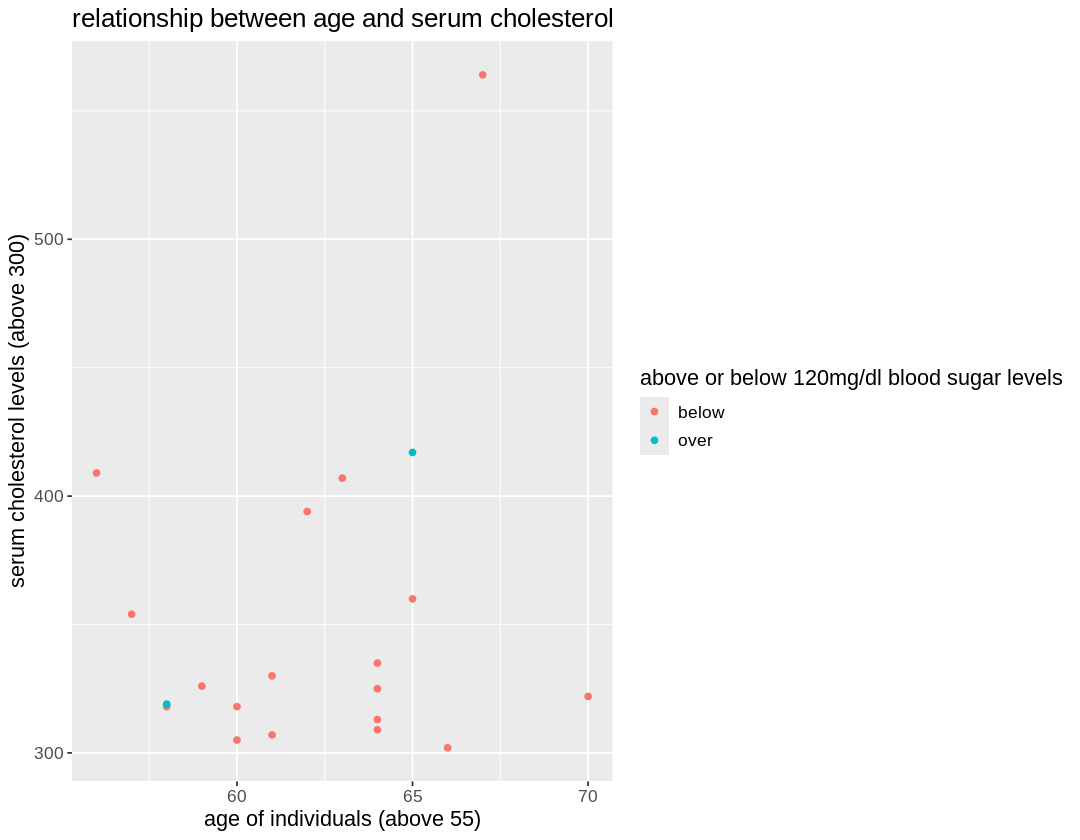

In [8]:
options(repr.plot.height = 7, repr.plot.width = 9)
cleveland_plot <- cleveland_train |>
        ggplot(aes ( x = age , y = cholesterol, colour = fasting_blood_sugar)) +
        geom_point() +
        labs(x = "age of individuals (above 55)", 
        y = "serum cholesterol levels (above 300)", 
             colour = "above or below 120mg/dl blood sugar levels") +
        ggtitle("relationship between age and serum cholesterol") +
    theme(text = element_text(size = 13))
cleveland_plot

I will analyse the data using the K-nearest neighbours classification. First, I’ll select the optimal K value with the highest accuracy using tune() on the validation dataset by plotting K vs. accuracy. After building my model, I will pre-process the training data, and I can predict the outcome on the test dataset to explore the relationship between age, serum cholesterol, and fasting blood sugar levels. Finally, I'll evaluate the classifier's performance using the confusion matrix.

EXPECTED OUTCOMES AND SIGNIFICANCE: 

I expect the classifier to predict that higher age and serum cholesterol levels will increase the risk of elevated fasting blood sugar (higher than 120 mg/dL). While these findings are not perfect, they can inform patients and enhance preventative care, promoting health programs for individuals with high cholesterol and advancing age. Additionally, this finding could provide a basis for further research, leading to new treatment and classification approaches. Future questions might explore whether age and cholesterol levels can predict specific types of diabetes or if there are demographic differences in the relationship between age, cholesterol, and blood sugar levels.

References: 

Crna, R. N. M. (2022, April 19). Everything you need to know about diabetes tests. Healthline. https://www.healthline.com/health/diabetes-tests#urine-tests

Diabetes - Diagnosis and treatment - Mayo Clinic. (2024, March 27). https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451

Hobbs, H. (2024, May 15). What is serum cholesterol and why is it important? Healthline. https://www.healthline.com/health/serum-cholesterol

Yi, S., Park, S., Lee, Y., Park, H., Balkau, B., & Yi, J. (2017). Association between fasting glucose and all-cause mortality according to sex and age: a prospective cohort study. Scientific Reports, 7(1). https://doi.org/10.1038/s41598-017-08498-6
